<a href="https://colab.research.google.com/github/Tj-dev-py/Covid-19-Computer-Vision-Project/blob/main/Covid_19_Computer_Vision_Project_(Version_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 Computer Vision Project (Version 2)

In this project, we will classify images of X-ray scans of people infected with Covid-19. The people whose scans have been taken are either infected, not-infected (i.e.: normal), or have another similar case of infection called Viral Pneumonia. As such, there are three classes our classification algorithm will predict.

The data can be found [here](https://www.kaggle.com/pranavraikokte/covid19-image-dataset) along with the documentation.

We'll start by collecting the data.

## Data Collection

We download the data from the aforementioned site and store it in a directory or subdirectory. We then zip the file and send it to google drive. We can mount our drive in google collab to get the data and use it here.

After that is done, we can then load the data using tensorflow and keras by using the `preprocessing.image_dataset_from_directory` function.

### Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Create Datasets

It's always a good idea to create train and validation splits for your model to learn from. This way, we can correct our model using its results from the validation data. 

In [ ]:
# set some initial parameters
img_height, img_width, batch_size = 256, 256, 32

In [ ]:
# create the training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/drive/MyDrive/Covid19-dataset/train',
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 251 files belonging to 3 classes.
Using 201 files for training.


2021-08-18 06:13:58.678887: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-08-18 06:13:58.678955: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ec3c2b83e776): /proc/driver/nvidia/version does not exist


In [ ]:
# create the validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/drive/MyDrive/Covid19-dataset/train',
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 251 files belonging to 3 classes.
Using 50 files for validation.


We can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
class_names

['Covid', 'Normal', 'Viral Pneumonia']

In [ ]:
type(class_names)

list

Here are some examples of the images we will be working with. We can take some of the images along with their respective classes from the training set.

### Display a Few Images

2021-08-18 06:13:58.957271: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


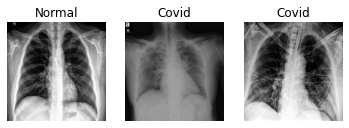

In [ ]:
plt.figure(figsize=(6, 6))

for images, labels in train_ds.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

### See the Batch Size
we can manually iterate over the dataset and retrieve batches of images.

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape, labels_batch.shape, sep='\n')
  break

(32, 256, 256, 3)
(32,)


The image_batch is a tensor of the shape (32, 256, 256, 3). This is a batch of 32 images of shape **256x256x3** (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

## Configure Dataset for Performance

In order to boost performance, we can use buffer prefetching to switch the way computer processors take intstuctions from the original slow memory, to a faster local memory. These are two important methods you should use when loading data: 

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the Data

Most image's RGB scales lie in the [0, 255] i.e.: 256 range. Most neural networks require ranges from 0 to 1 for it to be accurate in its predictions. Thus, we standardize the data  using the `preprocessing.Rescaling` function for all the images in the dataset.

We will use this layer inside our model during its construction as it's easier that way.



## Overfitting

This is an ubiquitous problem in machine learning. Overfitting occurs when the model does well on the training set but not so much on the validation or test set. To deal with this, we use techniques like data augmentation and adding dropout layers to our model.

### Data augmentation

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from tf.keras.layers.experimental.preprocessing. These can be included inside your model like other layers, and run on the GPU.




In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

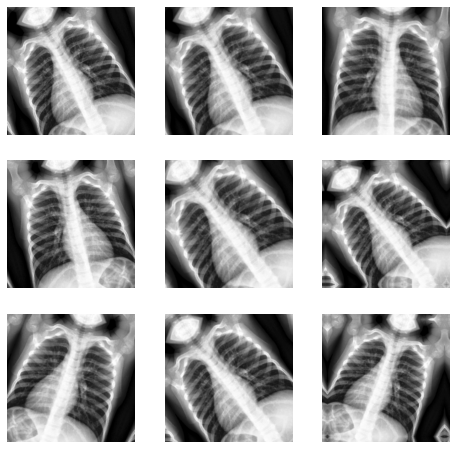

In [ ]:
plt.figure(figsize=(8, 8))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

###Dropout

Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using layers.Dropout and the data augmentation layer, then train it using those augmented images.




## Create the Model

In [ ]:
# setting the number of classes
num_classes = 3

model = Sequential([
                    
  # Base of the Classifier
  # _________________________

  # Adding augmentation layer
  data_augmentation, 

  # Standardizing data
  layers.experimental.preprocessing.Rescaling(1./255),

  # First convolutional block
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # Second convolutional block
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # Third convolutional block
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # Adding dropout layer
  layers.Dropout(.2),

  # Flattening the images to one dimension
  layers.Flatten(), 

  # Head of the classifier
  # _________________________

  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)

])

## Compile and train the model

Here, we compile a model using a loss function, an optimizer to reduce the loss and a metric for measuring the accuracy of the model.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# summary of our model's construction
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)       

### Set a Callback

Callbacks are a way to stop a model during training when it deosn't see any improvement in performance after a while. The callback we will use is called EarlyStopping. 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
)


In [ ]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/100
7/7 [==============================] - 21s 3s/step - loss: 1.6365 - accuracy: 0.5025 - val_loss: 0.9941 - val_accuracy: 0.7400
Epoch 2/100
7/7 [==============================] - 18s 3s/step - loss: 0.9327 - accuracy: 0.6517 - val_loss: 0.9996 - val_accuracy: 0.4400
Epoch 3/100
7/7 [==============================] - 18s 3s/step - loss: 0.7174 - accuracy: 0.6915 - val_loss: 0.6310 - val_accuracy: 0.7400
Epoch 4/100
7/7 [==============================] - 18s 3s/step - loss: 0.5601 - accuracy: 0.7065 - val_loss: 0.4024 - val_accuracy: 0.9000
Epoch 5/100
7/7 [==============================] - 18s 3s/step - loss: 0.4232 - accuracy: 0.8010 - val_loss: 0.4778 - val_accuracy: 0.8400
Epoch 6/100
7/7 [==============================] - 18s 3s/step - loss: 0.4243 - accuracy: 0.8109 - val_loss: 0.3836 - val_accuracy: 0.8400
Epoch 7/100
7/7 [==============================] - 18s 3s/step - loss: 0.3984 - accuracy: 0.8010 - val_loss: 0.3437 - val_accuracy: 0.9200
Epoch 8/100
7/7 [==========

## Visualize the results

We can look at the results of our model in the form of graphs. We'll convert the models runtime history to a dataframe, the plot the loss and accuracy.

In [ ]:
import pandas as pd

# as dataframe
history_df = pd.DataFrame(history.history)

# last few steps 
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
14,0.237280,0.900497,0.570228,0.84
15,0.236830,0.915423,0.632266,0.86
16,0.328331,0.895522,0.455630,0.90
17,0.268355,0.905473,0.452436,0.86
18,0.213128,0.925373,0.511535,0.88


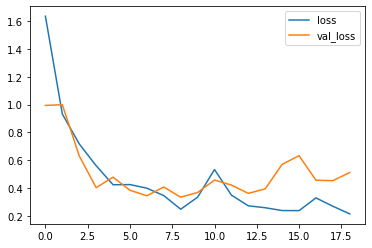

In [ ]:
# plotting results

history_df[['loss', 'val_loss']].plot()
plt.show()

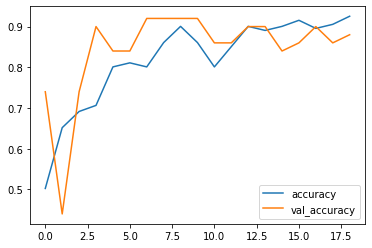

In [ ]:
history_df[['accuracy', 'val_accuracy']].plot()
plt.show()

## Testing the model

Now that the training and validation phase is over, we can test our model using the data from the collection phase.

In [ ]:
# create the test set
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/drive/MyDrive/Covid19-dataset/test',
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 66 files belonging to 3 classes.


In [ ]:
predictions = model.predict(test_ds)

In [ ]:
score = tf.nn.softmax(predictions[0])

In [ ]:
print(
    "This image most likely belongs to '{}' with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 'Normal' with a 93.09 percent confidence.


## Save the model


In [ ]:
tf.keras.models.save_model(model, 'Covid19_ComputerVisionProject_Version2_model.hdf5')

# Creating an Application

Now, we're going to take this project further and create an application where users can submit an X-ray scan of an infected/non-infected person and the model can classify them, predict and showcase the results in layman's terms to the user.

We'll be using a library called streamlit to do this. The code can be found in a seperate file called `Covid19_ComputerVisionProject_Version2_Application.py`